In [269]:
# Module import
from IPython.display import Image
import sys
import pandas as pd

# To use interact -- IPython widget
#from __future__ import print_function
#from ipywidgets import interact, interactive, fixed, interact_manual
#import ipywidgets as widgets


# append to path the folder that contains the analytic scanner
sys.path.append('../GaiaLab/scan/analytic_scanner')
# local imports
#from gaia_analytic_toymodel import *

from scipy import interpolate
import timeit

import frame_transformations as ft
from scanner import Scanner
from satellite import Satellite
from source import Source

import constants as const

from quaternion import Quaternion
from agis import Agis
from agis import Calc_source
from agis_functions import *

from analytic_plots import *

import astropy.units as u
import time

import scipy.sparse as sps

# Ipython magics
%load_ext autoreload
%autoreload 2
#%matplotlib notebook 
# %matplotlib widget
# %matplotlib ipympl
%reload_ext autoreload


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# **Initializing objects:**

In [244]:
# # create all the objects we will need:
# parameters for the notebook
t_init = 0 
t_end =  t_init + 1/24
my_dt = 1/24/60 # [days]

# objects
gaia = Satellite(ti=t_init, tf=t_end, dt= my_dt)
print('Sat created')

Sat created


In [245]:
double_telescope = False
my_scanner = Scanner(zeta_limit=np.radians(40) ,double_telescope=double_telescope) 
print('Scanner created')

num_sources=10

Scanner created


In [246]:
# Warning be carefull to what you use to get alpha/delta from vector
alphas, deltas = ([], [])
for t in np.linspace(t_init+my_dt, t_end, num=num_sources, endpoint=False):
    attitude = gaia.func_attitude(t)
    alpha, delta = generate_observation_wrt_attitude(attitude)
    alphas.append(alpha)
    deltas.append(delta)

In [247]:
# Generate telescopes positions
alphas_P, deltas_P, alphas_F, deltas_F = ([], [], [], [])
for t in np.linspace(t_init, t_end, num=100):
    a_P, d_P, a_F, d_F = get_angular_FFoV_PFoV(gaia, t)
    alphas_P.append(a_P-np.pi)
    deltas_P.append(d_P)
    alphas_F.append(a_F-np.pi)
    deltas_F.append(d_F)

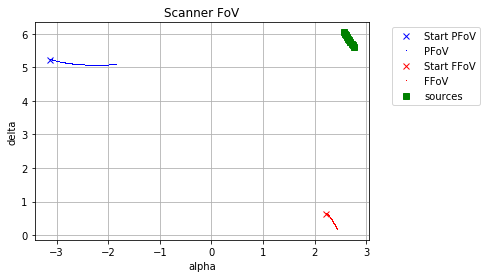

In [248]:
fig = plt.figure()
#plt.plot(aplhas[0], deltas[0], 's')
plt.plot(alphas_P[0], deltas_P[0], 'bx', label='Start PFoV')
plt.plot(alphas_P, deltas_P, 'b,', label='PFoV')
plt.plot(alphas_F[0], deltas_F[0], 'rx', label='Start FFoV')
plt.plot(alphas_F, deltas_F, 'r,', label='FFoV')

plt.plot(alphas[0]-np.pi, deltas[0], 'gs', label='sources')
for a,d in zip(alphas[1:], deltas[1:]):
    plt.plot(a-np.pi, d, 'gs')

plt.title("Scanner FoV")
plt.legend(loc=9, bbox_to_anchor=(1.2, 1))
plt.grid(True), plt.xlabel('alpha'), plt.ylabel('delta')
plt.show()

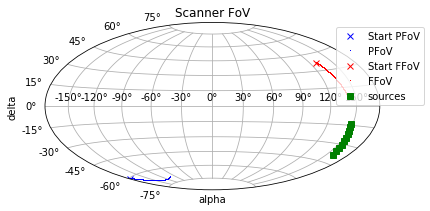

In [249]:
fig = plt.figure()
plt.subplot(111, projection="hammer")
#plt.plot(aplhas[0], deltas[0], 's')
plt.plot(alphas_P[0], deltas_P[0], 'bx', label='Start PFoV')
plt.plot(alphas_P, deltas_P, 'b,', label='PFoV')
plt.plot(alphas_F[0], deltas_F[0], 'rx', label='Start FFoV')
plt.plot(alphas_F, deltas_F, 'r,', label='FFoV')

plt.plot(alphas[0]-np.pi, deltas[0], 'gs', label='sources')
for a,d in zip(alphas[1:], deltas[1:]):
    plt.plot(a-np.pi, d, 'gs')

plt.title("Scanner FoV")
plt.legend(loc=9, bbox_to_anchor=(1, 1))
plt.grid(True), plt.xlabel('alpha'), plt.ylabel('delta')
plt.show()

In [250]:
# create soures from that: 
sources = []
for n in range(num_sources):
    sources.append(Source(str(n), np.degrees(alphas[n]), np.degrees(deltas[n]), 0, 0, 0, 0))
    # sources.append(Source(str(n), alphas[n], deltas[n], parallaxes[n], mu_alphas[n], mu_deltas[n], mu_radials[n]))
print('Sources created')

Sources created


# **Scan**

In [260]:
obs_times = []
calc_sources = []
real_sources = []
for s in sources:
    my_scanner.scan(gaia, s, ti=t_init, tf=t_end)
    my_scanner.compute_angles_eta_zeta(gaia, s)
    print('zetas:', my_scanner.zeta_scanned)
    print('etas:', my_scanner.eta_scanned)
    print('times:', my_scanner.obs_times)
    print('How many observation time?  {}'.format(len(my_scanner.obs_times)))
    if len(my_scanner.obs_times)>0:
        obs_times += my_scanner.obs_times
        print('Error: ', my_scanner.scanner_error())
        real_sources.append(s)
        calc_sources.append(Calc_source(obs_times=my_scanner.obs_times, source=s))
    print('------------------------------------------------------')
sources = real_sources
obs_times = list(np.sort(obs_times))

Starting scan with time from 0 to 0.041666666666666664 days
Total measured time: 0.0016684532165527344
zetas: [2.3592239273284576e-16]
etas: [0.0]
times: [0.0006944444444445062]
How many observation time?  1
Error:  0.0
------------------------------------------------------
Starting scan with time from 0 to 0.041666666666666664 days
Total measured time: 0.0043070316314697266
zetas: [-5.551115123125783e-16]
etas: [2.7755575615628914e-17]
times: [0.0047916666666666975]
How many observation time?  1
Error:  2.7755575615628914e-17
------------------------------------------------------
Starting scan with time from 0 to 0.041666666666666664 days
Total measured time: 0.0020341873168945312
zetas: [1.8735013540549512e-16]
etas: [-3.608224830031758e-16]
times: [0.008888888888888915]
How many observation time?  1
Error:  -3.608224830031758e-16
------------------------------------------------------
Starting scan with time from 0 to 0.041666666666666664 days
Total measured time: 0.00128841400146484

# **2- Combine with solver:**

In [261]:
len(sources)

5

In [262]:
def noise_calc_sources(s):
    noise = 0.02 / 10
    s.s_params[0] += noise
    s.s_params[1] += noise
    s.s_params[2] += -s.s_params[2]/100
    s.s_params[3] += s.s_params[3]*0.01
    s.s_params[4] += s.s_params[4]*0.01

In [263]:
print('Updating only sources:')
Solver = Agis(gaia, calc_sources, sources, updating='scanned source', double_telescope=double_telescope)

Updating only sources:


In [264]:
Solver.error_function()

0.0

In [265]:
# Solver.reset_iterations()
#Solver.iterate(1)

# *Update Attitude*

In [286]:
print('Updating attitude')
spline_degree = 3
Solver = Agis(gaia, calc_sources, real_sources=sources, updating='attitude',
              double_telescope=double_telescope,
              attitude_splines=[gaia.s_w, gaia.s_x, gaia.s_y, gaia.s_z], 
              spline_degree=spline_degree,
              attitude_regularisation_factor=1e-2)

Updating attitude


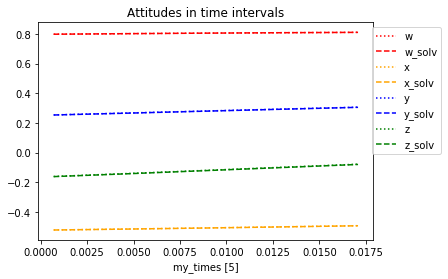

In [287]:
compare_attitudes(gaia, Solver, obs_times)

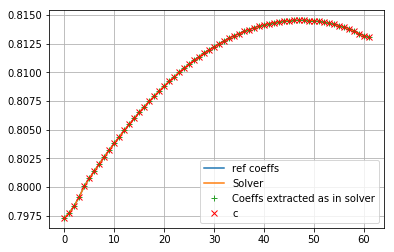

(None, <matplotlib.legend.Legend at 0x7f2e226fec18>, None)

In [288]:
to_fit = gaia.s_w
c, t, s = extract_coeffs_knots_from_splines([gaia.s_w, gaia.s_x, gaia.s_y, gaia.s_z], k=3)
a_ref = to_fit.get_coeffs()
plt.plot(a_ref, label='ref coeffs')
plt.plot(Solver.att_coeffs[0], label='Solver')
plt.plot(c[0], '+', label='Coeffs extracted as in solver')
plt.plot(Solver.c[0], 'rx', label='c')
plt.grid(), plt.legend(), plt.show()

In [289]:
# Ignore this cell if you don't want to modify the initial attitude
# Can be used to check that when recreating the splines in the solver we (almost) do not create additional errors
my_times = np.array(obs_times)
# Solver.actualise_splines()
print('Error before Noise: ', Solver.error_function())
# print('Errors after noise of attitude (not representatif):', error_between_func_attitudes(my_times, gaia.func_attitude, Solver.get_attitude))
c_noise = Solver.att_coeffs * np.random.rand(Solver.att_coeffs.shape[0], Solver.att_coeffs.shape[1]) * 1e-8
print('c_noise shape: ', c_noise.shape)
Solver.att_coeffs[:] = Solver.att_coeffs[:] + c_noise[:]
Solver.actualise_splines()
#Solver.set_splines_basis()
print('Error after Noise: ', Solver.error_function())
# print('Errors after noise of attitude (not representatif):', error_between_func_attitudes(my_times, gaia.func_attitude, Solver.get_attitude))

Error before Noise:  9.549161584688579e-05
c_noise shape:  (4, 62)
Error after Noise:  9.549149748023985e-05


**Plot matrices:**

In [290]:
print(Solver.att_knots.shape[0])
print(Solver.att_coeffs.shape[1])

65
62


In [293]:
N_aa = Solver.compute_attitude_LHS()

N_aa_dim: 62


In [294]:
N_aa_w = N_aa[0::4, 0::4]
N_aa_x = N_aa[1::4, 1::4]
N_aa_y = N_aa[2::4, 2::4]
N_aa_z = N_aa[3::4, 3::4]
N_aa_list = [N_aa_w, N_aa_x, N_aa_y, N_aa_z]
print('N_aa_w.shape', N_aa_w.shape)
print('N_aa_z.shape', N_aa_z.shape)

N_aa_w.shape (62, 62)
N_aa_z.shape (62, 62)


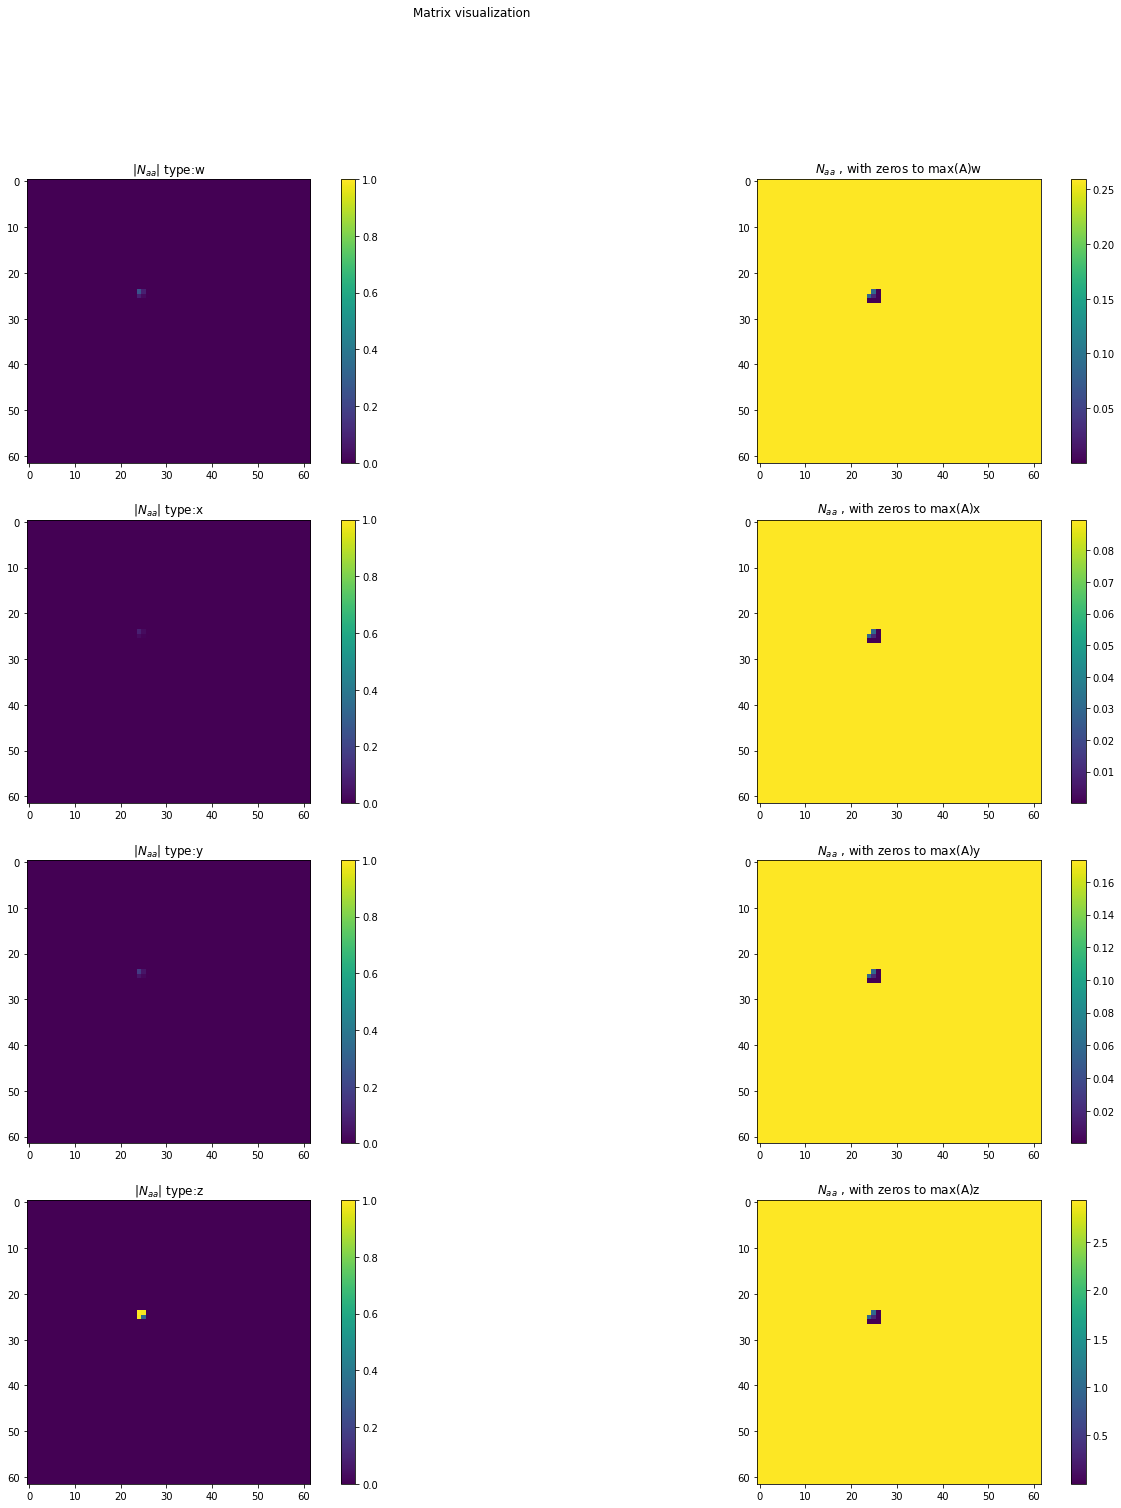

In [295]:
fig, axs = plt.subplots(4, 2, figsize=(24, 24))

type_list = ['w', 'x', 'y', 'z']
for i in range(4):
    A = N_aa_list[i].copy()
    plot1 = axs[i, 0].imshow(np.abs(A), vmin=None, vmax=1)
    axs[i, 0].set_title("$|N_{aa}|$ type:"+type_list[i])
    
    threshold = 0
    A[np.where(A==threshold)] = A.max()
    plot2 = axs[i, 1].imshow(A, vmin=None, vmax=None)
    axs[i, 1].set_title("$N_{aa}$ , with zeros to max(A)"+type_list[i])

    fig.colorbar(plot1, ax=axs[i, 0])
    fig.colorbar(plot2, ax=axs[i, 1])
    
fig.suptitle('Matrix visualization')
plt.show()

# **See iterations**

In [296]:
Solver.verbose=False
# Solver.reset_iterations()
Solver.iterate(1)

plt.figure(figsize=(5,5))
c, t, s = extract_coeffs_knots_from_splines([gaia.s_w, gaia.s_x, gaia.s_y, gaia.s_z], k=3)
plt.plot(c[0], '+', label='Coeffs extracted as in solver')
plt.plot(Solver.att_coeffs[0], label='Solver')
plt.grid(), plt.legend(), plt.show()
multi_compare_attitudes(gaia, Solver, my_times)
print('MAGNITUDE:', Solver.get_attitude(0.005, unit=False).magnitude)

***** Iteration: 1 *****
N_aa_dim: 62


LinAlgError: Singular matrix